In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import cv2

import h5py

In [2]:
batch_size1=32

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
y_train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Coloring/Datasets/train_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='rgb',seed=61) 

Found 8294 images belonging to 1 classes.


In [6]:
x_train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/bw_train_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='grayscale',seed=61) 

Found 8294 images belonging to 1 classes.


In [7]:
x_val_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/bw_val_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='grayscale',seed=61) 

Found 1000 images belonging to 1 classes.


In [8]:
y_val_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/val_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='rgb',seed=61) 

Found 1000 images belonging to 1 classes.


In [11]:
#densenet model

dense_model=tf.keras.applications.DenseNet121(include_top=True, weights='imagenet', input_shape=(224,224,3))

for l in dense_model.layers:
  l.trainable=False


In [12]:
#create a model

input1=keras.layers.Input(shape=(224,224,1))

input2=keras.layers.concatenate([input1,input1,input1])



h1=keras.layers.Conv2D(32,(3,3),padding='same')(input1)
#h1=keras.layers.Conv2D(32,(3,3))(h1)
h1=keras.layers.BatchNormalization()(h1)
h1=keras.layers.LeakyReLU(alpha=0.2)(h1)
h1=keras.layers.MaxPooling2D((2,2),2)(h1)


h2=keras.layers.Conv2D(64,(3,3),padding='same')(h1)
#h2=keras.layers.Conv2D(64,(3,3))(h2)
h2=keras.layers.BatchNormalization()(h2)
h2=keras.layers.LeakyReLU(alpha=0.2)(h2)
h2=keras.layers.MaxPooling2D((2,2),2)(h2)

h3=keras.layers.Conv2D(128,(3,3),padding='same')(h2)
#h3=keras.layers.Conv2D(128,(3,3))(h3)
h3=keras.layers.BatchNormalization()(h3)
h3=keras.layers.LeakyReLU(alpha=0.2)(h3)
h3=keras.layers.MaxPooling2D((2,2),2)(h3)

#fusion

dense_out=dense_model(input2)

fusion_output = keras.layers.RepeatVector(28 * 28)(dense_out) 
fusion_output = keras.layers.Reshape(([28, 28, 1000]))(fusion_output)

fusion_output1=keras.layers.concatenate([h3,fusion_output],axis=3)
fusion_output1 =keras.layers.Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output1)

##decoder

h4=keras.layers.Conv2D(128,(3,3),padding='same')(fusion_output1)
#h4=keras.layers.Conv2D(256,(3,3))(h4)
h4=keras.layers.BatchNormalization()(h4)
h4=keras.layers.LeakyReLU(alpha=0.2)(h4)
h4=keras.layers.UpSampling2D((2,2))(h4)

#h4=keras.layers.Conv2D(256,(3,3),padding='valid')(h4)

#h5=keras.layers.UpSampling2D()(h4)
h5=keras.layers.Conv2D(64,(3,3),padding='same',name='decoder_starts')(h4)
h5=keras.layers.BatchNormalization()(h5)
h5=keras.layers.LeakyReLU(alpha=0.2)(h5)
h5=keras.layers.UpSampling2D((2,2))(h5)

h6=keras.layers.Conv2D(32,(3,3),padding='same')(h5)
h6=keras.layers.BatchNormalization()(h6)
h6=keras.layers.LeakyReLU(alpha=0.2)(h6)
h6=keras.layers.UpSampling2D((2,2))(h6)

h7=keras.layers.Conv2D(3,(3,3),padding='same')(h6)
#h7=keras.layers.BatchNormalization()(h7)
#h7=keras.layers.LeakyReLU(alpha=0.2)(h7)
#h7=keras.layers.UpSampling2D((2,2))(h7)

#h7=keras.layers.Conv2D(3,(3,3),padding='same')(h7)



output=h7

model=keras.Model(inputs=input1, outputs=output)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, verbose=1, min_delta=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=10, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [14]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
#history=model.fit_generator(train_generator,epochs=1,callbacks=callbacks_list)

#history=model.fit(train_generator,test_generator,steps_per_epoch=9246//1,epochs=2)

history=model.fit(zip(x_train_generator,y_train_generator),steps_per_epoch=8246//batch_size1,epochs=150,callbacks=callbacks_list,validation_data =zip(x_val_generator,y_val_generator) ,validation_steps=1000//batch_size1)
#history=model.fit(zip(test_generator,train_generator),steps_per_epoch=9246//batch_size1,epochs=600)


Epoch 1/150
257/257 [==============================] - 9547s 37s/step - loss: 0.0271 - val_loss: 0.0633
Epoch 2/150
257/257 [==============================] - 238s 927ms/step - loss: 0.0144 - val_loss: 0.0196
Epoch 3/150
257/257 [==============================] - 198s 770ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 4/150
257/257 [==============================] - 194s 755ms/step - loss: 0.0129 - val_loss: 0.0162
Epoch 5/150
257/257 [==============================] - 187s 727ms/step - loss: 0.0125 - val_loss: 0.0146
Epoch 6/150
257/257 [==============================] - 190s 737ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 7/150
257/257 [==============================] - 188s 732ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 8/150
257/257 [==============================] - 189s 735ms/step - loss: 0.0115 - val_loss: 0.0132
Epoch 9/150
257/257 [==============================] - 191s 742ms/step - loss: 0.0112 - val_loss: 0.0138
Epoch 10/150
257/257 [==============================] - 

In [15]:
model.save('/content/drive/My Drive/Coloring/Autoencoder_fusion_densenet_colorizer.h5')

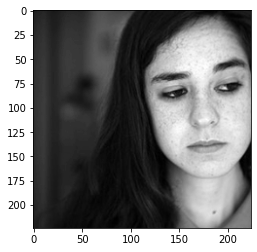

In [ ]:
image=mpimg.imread('f1.jpg')
image=cv2.resize(image,(224,224))

image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(image,cmap='gray')
image=image/255.0
image1=image.reshape(1,224,224,1)

p=model.predict(image1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


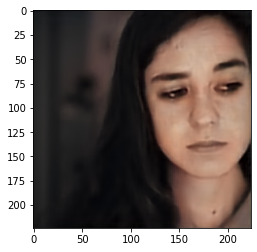

In [ ]:
plt.imshow(p[0])

(1, 224, 224, 1)